<a href="https://colab.research.google.com/github/KTH-EXPECA/summer-school-2025/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Install and Load Data

In this section, we will:  
1. **Install dependencies**  
2. **Download the dataset**  
3. **Import required Python packages**

In [1]:
# Install dependencies
!pip install scipy
!pip install git+https://github.com/samiemostafavi/pr3d.git@develop

In [4]:
# Download datasets from Github
!mkdir -p /content/data
!curl -L -o /content/data/dataset.zip "https://github.com/KTH-EXPECA/summer-school-2025/raw/refs/heads/main/dataset.zip"
!unzip -q -o /content/data/dataset.zip
!rm -rf /content/data
!rm -rf /content/__MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.5M  100 20.5M    0     0  33.0M      0 --:--:-- --:--:-- --:--:-- 33.0M


In [5]:
# Import required packages
import pickle, json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Open the datasets and inspect their contents

We first load the dataset file (`dataset.pkl`) which contains several experiments.  
For each experiment, we will:  

- Show the **metadata** describing the experiment setup.  
- Display the **dataframe shape** (rows × columns) and its available columns.  
- Filter the records where `segment == -1` (indicates only packet records).  
- Compute basic **statistics**:
  - Packet length  
  - Average and standard deviation of MCS index  
  - Average number of HARQ retransmissions  
  - Average number of RLC retransmissions
  - Average latency of the Packet

💡 **Note:** The metadata field `arrivals_num` indicates the **number of packet arrivals** in each experiment.

This gives a quick overview of what is inside each dataset before we dive deeper.

👉 **Question to think about:**  
Can you find relationships between the **average packet delay** and the other properties (MCS, retransmissions, packet length) in each experiment?

In [6]:
pkl_path = Path("/content/dataset.pkl")
with open(pkl_path, "rb") as f:
    datasets = pickle.load(f)

datasets_dict = {}
for i, item in enumerate(datasets, 1):
    df = pd.DataFrame(item.get("dataset"))
    meta = {k: v for k, v in item.items() if k not in ["dataset", "db_id"]}

    # filter
    packets_df = df[df["segment"] == -1].copy()
    packets_df['packet_delay_ms'] = (
        packets_df['depart_timestamp'].astype(float) - packets_df['timestamp'].astype(float)
    ) * 1000

    # compute stats
    stats = {
        "Mean Packet Length": np.mean(packets_df["len"]),
        "Mean MCS Index": np.mean(packets_df["mcs_index"]),
        "Std MCS Index": np.std(packets_df["mcs_index"]),
        "Mean HARQ Retx.": np.mean(packets_df["mretx"]),
        "Mean RLC Retx.": np.mean(packets_df["rfailed"]),
        "Mean Latency": np.mean(packets_df["packet_delay_ms"]),
    }

    # pretty print
    print(f"\n{'='*25} DATASET {i} {'='*25}")
    print("Meta information:")
    display(pd.DataFrame([meta]))   # nicely formatted as a table
    print("\nStatistics:")
    display(pd.DataFrame([stats]))
    print(f"\nDataFrame shape: {df.shape}, columns: {list(df.columns)}")

    datasets_dict[item['dataset_name']] = packets_df

datasets = datasets_dict


========================= DATASET 1 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e20,77e2,90306,18061



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,127.940701,23.919274,1.643363,0.487625,1.13089,47.819503



DataFrame shape: (90306, 13), columns: ['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']

========================= DATASET 2 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e4,a431,146421,36602



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,227.88946,20.0,0.0,0.000109,0.00112,18.853617



DataFrame shape: (146421, 13), columns: ['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']

========================= DATASET 3 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e19,37ff,89016,18058



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,127.940691,22.675767,1.490224,0.568668,1.043803,43.780747



DataFrame shape: (89016, 13), columns: ['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']

========================= DATASET 4 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e6,71f5,146155,36532



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,1027.38558,20.0,0.0,0.003668,0.00063,19.210568



DataFrame shape: (146155, 13), columns: ['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']

========================= DATASET 5 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e8,2779,256363,73053



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,1023.674127,19.563276,0.590081,0.209095,0.001122,21.4974



DataFrame shape: (256363, 13), columns: ['segment', 'packet_id', 'depart_timestamp', 'timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']

========================= DATASET 6 =========================
Meta information:


,dataset_name,stream_rnti,size,arrivals_num
0,e7,e595,252737,72214



Statistics:


,Mean Packet Length,Mean MCS Index,Std MCS Index,Mean HARQ Retx.,Mean RLC Retx.,Mean Latency
0,773.760019,20.0,0.0,0.082366,0.000291,20.585431



DataFrame shape: (252737, 13), columns: ['segment', 'packet_id', 'depart_timestamp', 'timestamp', 'slot', 'len', 'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols', 'time_since_start', 'time_since_last_event']


### Step 3: Exploring Packet Delay Reliability

We now have experiments labeled **e4, e6, e7, e8, e19, and e20**, with all packet dataframes stored inside the `datasets` dictionary.  

Our next goal is to **analyze packet delays more deeply** by looking at the frequency of outliers (delay spikes) in a **probabilistic way**. This type of analysis helps us understand the **reliability of a 5G link** for time-critical applications.  

Specifically, we will:  
- Plot the **time series** of packet delays  
- Compute and visualize the **empirical PDF**  
- Plot the **log(CCDF)** (tail probability)  

---

💡 **Task:**  
Extended Reality (XR) applications require packet delays below **50 ms** with probability **0.999**.  

1. Write a function that:  
   - Takes a dataframe of packet delays  
   - Checks if the requirement is satisfied  
   - Returns `True` if the service-level requirement is met, otherwise `False`  

2. Run this function on each experiment (`e4, e6, e7, e8, e19, e20`) and compare the results.  

This will tell us which 5G experiment setups are reliable enough for XR applications.

In [5]:
# function definintions

def plot_time_series_plot(df):

    df['packet_delay_ms'] = (df['depart_timestamp'].astype(float) - df['timestamp'].astype(float)) * 1000
    packet_delays_ms = df['packet_delay_ms'].tolist()

    plt.figure(figsize=(6, 3))
    plt.plot(df['packet_delay_ms'].values)
    plt.xlabel('Time')
    plt.ylabel('Packet delay (ms)')
    plt.title('Packet delay over time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pdf_plot(df):

    # Use the same delays column you computed
    delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()

    # Keep only [0, 400] ms for the plot domain
    mask = (delays >= 0) & (delays <= 400)
    delays_clip = delays[mask]

    # Histogram as PDF (area = 1). 2 ms bins across 0–400 ms -> 200 bins
    bins = np.linspace(0, 400, 201)
    pdf_vals, bin_edges = np.histogram(delays_clip, bins=bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.figure(figsize=(5, 3))
    plt.plot(bin_centers, pdf_vals)
    #plt.xlim(0, 400)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('PDF')
    plt.title('Packet Delay Empirical PDF')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_ccdf_log(df):

    # calculate CCDF
    delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
    delays.sort()                              # ascending
    n = delays.size
    ccdf = 1.0 - (np.arange(1, n + 1) / n)     # empirical CCDF = 1 - ECDF

    # plot CCDF
    plt.figure(figsize=(5, 3))
    plt.step(delays, ccdf, where='post')       # survival curve style
    plt.yscale('log')
    #plt.xlim(0, 400)
    plt.ylim(1e-5, 1)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('CCDF  (P[Delay > x])')
    plt.title('Packet Delay Empirical CCDF')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()

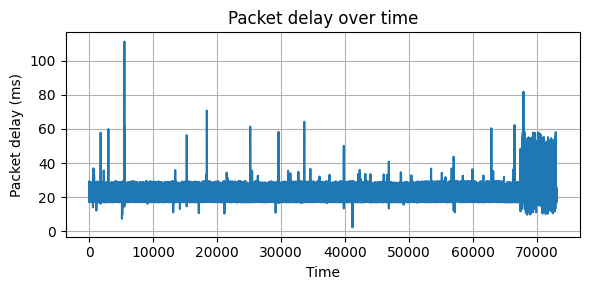

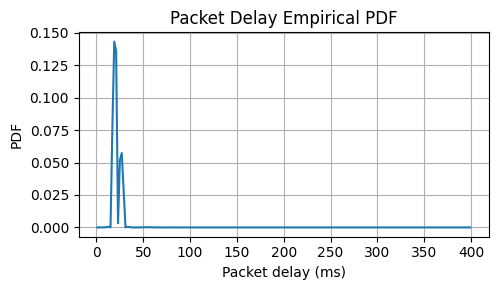

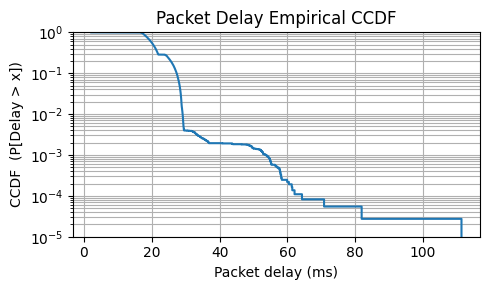

In [6]:
# Plot timeseries and probabilities for experiment 'e8'

e8_df = pd.DataFrame(datasets['e8'])
plot_time_series_plot(e8_df)
plot_pdf_plot(e8_df)
plot_ccdf_log(e8_df)

In [2]:
!pip uninstall -y pr3d
!pip install git+https://github.com/samiemostafavi/pr3d.git@develop

Found existing installation: pr3d 0.0.1
Uninstalling pr3d-0.0.1:
  Successfully uninstalled pr3d-0.0.1
  Cloning https://github.com/samiemostafavi/pr3d.git (to revision develop) to /tmp/pip-req-build-8ghdn725
  Running command git clone --filter=blob:none --quiet https://github.com/samiemostafavi/pr3d.git /tmp/pip-req-build-8ghdn725
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/samiemostafavi/pr3d.git to commit ff9e8c8d7f5e3886940f532ea5d4f443e0d11c04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pr3d: filename=pr3d-0.0.1-py3-none-any.whl size=39581 sha256=16bb681f46c80213741d51ca487288f5fa27ec24b1cedb8fcfccb4e49f534d82
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7n8q466/wheels/2e/f1/46/c7fb0202d4cdd4342fc69e7b7361

### Step 4: Train a Single-Layer Perceptron for Latency Distribution

Now we will train a **single-layer perceptron (SLP)** to model the latency distribution.
As you observed, the latency distribution is **not unimodal** (i.e., not a simple Gaussian).  
To capture its multi-modal nature, we use a **mixture model** and optimize it with **negative log-likelihood (NLL)**.

#### What we do in this step

- **Extract delays** from each dataset and (optionally) **standardize** them  
  \- We compute `y_mean` and `y_std` and transform `Y → (Y - y_mean)/y_std`.  
  \- We keep (`y_mean`, `y_std`) to map model outputs back to milliseconds later.

- **Build a non-conditional model** (SLP) that outputs the parameters of a **K-component Gaussian Mixture (GMM)**:  
  \- **mixture_weights**, **mixture_locations** (means), **mixture_scales** (stds).  
  \- Because it’s non-conditional, the input is just a **dummy vector of zeros** (placeholder).

- **Subsample** a manageable number of points (`num_samples`) for quick training, then split into  
  **train/validation** sets (e.g., 80/20) to monitor generalization.

- **Train with NLL loss** using mini-batches (`batch_size`) for `num_epochs` with Adam (`learning_rate`).  
  \- **Lower loss / val_loss** indicates a better fit to the observed delay distribution.

In [31]:
from pr3d.de import GaussianMM, GaussianMixtureEVM, GammaMixtureEVM
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# training function
def train_slp_gmm_model(
    num_centers,
    df,
    num_samples,
    batch_size,
    num_epochs,
    learning_rate,
    standardize,
    val_fraction=0.2,   # fraction of samples for validation
):

    model = GaussianMM(centers=num_centers)

    # --- Prepare data ---
    delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
    Y = np.asarray(delays, dtype=np.float64).reshape(-1, 1)

    if standardize:
        y_mean = float(Y.mean())
        y_std  = float(Y.std() + 1e-8)   # avoid divide-by-zero
    else:
        y_mean = 0.0
        y_std  = 1.0

    Yz = (Y - y_mean) / y_std

    # Ensure shapes are (N,1)
    Xz = np.zeros((len(Yz), 1))
    Yz = np.asarray(Yz).reshape(-1, 1)

    # pick a subset of training samples
    idx = np.random.choice(len(Yz), size=num_samples, replace=False)
    X_sub = Xz[idx]
    Y_sub = Yz[idx]

    # --- Train/validation split ---
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_sub, Y_sub, test_size=val_fraction, random_state=42
    )

    # --- Training rounds ---
    training_rounds = [{"learning_rate": learning_rate, "epochs": num_epochs}]

    for i, rp in enumerate(training_rounds, 1):
        print(f"Training session {i}/{len(training_rounds)} with {rp}")

        model.training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=rp["learning_rate"]),
            loss=model.loss,
        )

        history = model.training_model.fit(
            x=[X_train, Y_train],
            y=Y_train,
            batch_size=batch_size,
            epochs=rp["epochs"],
            verbose=1,
            shuffle=True,
            validation_data=([X_val, Y_val], Y_val),
        )

    return model, y_mean, y_std, history


def plot_ccdf_pdf_with_model(
    df,
    model,
    max_x: float = 400.0,
    num_points: int = 1200,
    batch_size: int = 2048,
    y_mean: float | None = None,
    y_std: float | None = None,
    pdf_bins: int = 400,
    use_kde: bool = False,
):
    """
    delays_ms : 1D array of delays (ms)
    model     : your GaussianMM instance (with .prob_pred_model)
    y_mean,y_std : if you trained on standardized targets, pass them here
    """

    # ----- Clean & sort data -----
    delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
    delays = delays[(delays >= 0) & (delays <= max_x)]
    delays.sort()
    n = delays.size
    if n == 0:
        raise ValueError("No valid delay samples in range.")

    # ----- Empirical CCDF -----
    emp_ccdf = 1.0 - (np.arange(1, n + 1) / n)

    # ----- Grid for model curves -----
    grid_y = np.linspace(0.0, max_x, num_points)

    # If trained on z, feed z into the model
    if (y_mean is not None) and (y_std is not None):
        z = (grid_y - y_mean) / (y_std + 1e-12)
        jac = 1.0 / (y_std + 1e-12)  # for PDF only
    else:
        z = grid_y
        jac = 1.0

    # dtype & shapes for model inputs
    try:
        dtype_np = getattr(model, "dtype").as_numpy_dtype
    except Exception:
        dtype_np = np.float64

    X_dummy = np.zeros_like(z, dtype=dtype_np).reshape(-1, 1)
    Y_in    = np.asarray(z, dtype=dtype_np).reshape(-1, 1)

    # Predict model pdf/logpdf/ecdf
    pdf_m, logpdf_m, ecdf_m = model.prob_pred_model.predict(
        [X_dummy, Y_in], batch_size=batch_size, verbose=0
    )
    pdf_m   = np.squeeze(pdf_m)   * jac         # scale pdf if standardized
    ccdf_m  = 1.0 - np.squeeze(ecdf_m)         # ccdf unaffected by affine scale

    # ----- Empirical PDF (KDE or histogram density) -----
    # Try KDE for smooth curve; fallback to histogram
    emp_x_pdf = None
    emp_pdf   = None
    if use_kde:
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(delays)
            emp_x_pdf = grid_y
            emp_pdf   = kde(emp_x_pdf)
        except Exception:
            pass

    if emp_pdf is None:
        # Histogram density estimate
        counts, edges = np.histogram(delays, bins=pdf_bins, range=(0, max_x), density=True)
        emp_x_pdf = 0.5 * (edges[:-1] + edges[1:])
        emp_pdf   = counts

    # ===================== PLOTS =====================

    # CCDF
    plt.figure(figsize=(5, 3))
    plt.step(delays, emp_ccdf, where='post', label='Empirical CCDF')
    plt.plot(grid_y, ccdf_m, label='Predicted CCDF')
    plt.yscale('log')
    plt.xlim(0, max_x)
    plt.ylim(1e-5, 1)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('CCDF  (P[Delay > x])')
    plt.title('Packet Delay CCDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PDF
    plt.figure(figsize=(5, 3))
    # empirical (step if hist; line if KDE)
    if len(emp_x_pdf) == len(grid_y):
        plt.plot(emp_x_pdf, emp_pdf, label='Empirical PDF')
    else:
        plt.step(emp_x_pdf, emp_pdf, where='mid', label='Empirical PDF')
    # model
    plt.plot(grid_y, pdf_m, label='Predicted PDF')
    plt.xlim(0, max_x)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('PDF')
    plt.title('Packet Delay PDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()



⬇️ **Run the code cell below to train**  

In [29]:
# Train a single layer perceptron GMM model
model, y_mean, y_std, history = train_slp_gmm_model(
    num_centers = 8,
    df = datasets['e20'],
    num_samples = 200,
    batch_size = 32,
    num_epochs = 100,
    learning_rate = 0.001,
    standardize = True,
    val_fraction=0.2
)

Training session 1/1 with {'learning_rate': 0.001, 'epochs': 100}
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 1.2344 - val_loss: 1.1895
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1966 - val_loss: 1.1819
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1877 - val_loss: 1.1744
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1690 - val_loss: 1.1673
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1866 - val_loss: 1.1601
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1428 - val_loss: 1.1529
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1426 - val_loss: 1.1458
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1658 - val_loss: 1.1390
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1906 - val_loss: 1.1319
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2056 - val_loss: 1.1249
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1848 - val_loss: 1.1179
Epoch 12

Next, **plot the results** to evaluate how well the model captures the data:

- Empirical **PDF**
- **log(CCDF)** (tail probability), which is what we use to assess reliability

⬇️ **Run the plotting code cell**

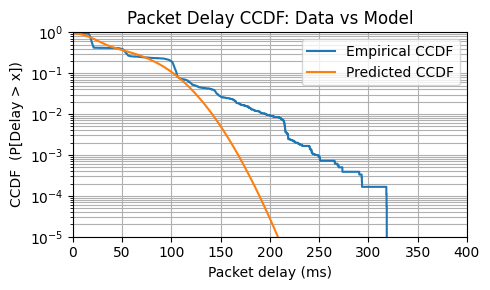

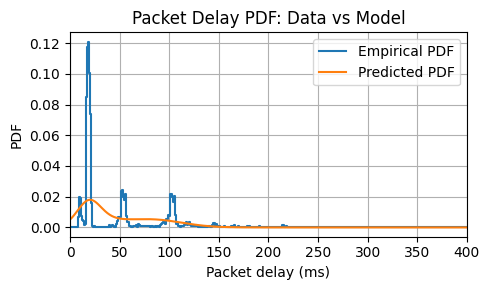

In [32]:
# plot the model prediction
plot_ccdf_pdf_with_model(datasets['e20'], model, 400, y_mean=y_mean, y_std=y_std)

Now investigate **how the number of training samples** affects accuracy for high reliability services.
As you **decrease** the number of training samples, model uncertainty typically **increases**, and the tail fit may become inaccurate.

**What to do:**
1. Train multiple models with different `num_samples` (e.g., **100**, **200**, **2,000**).
2. For each model compare the fitted mixture to the **empirical** estimate from data.
3. Identify which experiments and which quantiles the model struggles to predict accurately.


In [46]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import keras
from keras import layers, ops as kops
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pr3d.common.core import NonConditionalDensityEstimator

def safe_log(x, eps=1e-40):
    """log clipped to avoid -inf."""
    return tf.math.log(tf.maximum(x, tf.constant(eps, dtype=x.dtype)))

# ------------------------------------------------------------------
# Helper: safe support check + ξ≈0 (exponential) fallback
# ------------------------------------------------------------------
def _gpd_core(z, xi, scale, norm, dtype):
    """
    Core of the GPD pdf / survival / quantile with full ξ∈ℝ support.
    z        : (y - u) / σ    (non-negative tensor)
    xi       : shape ξ        (can be negative, zero, or positive)
    scale    : σ              (must be >0)
    norm     : “normalising” factor coming from the bulk / tail split
    """
    eps = tf.constant(1e-12, dtype=dtype)
    is_exp = tf.abs(xi) < eps          # ξ≈0 → exponential limit

    # 1 + ξ z  (needed many times)
    one_plus = 1. + xi * z

    # ----------------------------------------------------------------
    # pdf
    # ----------------------------------------------------------------
    pdf_gp  = norm / scale * tf.pow(one_plus, -1. - 1./xi)           # ξ≠0
    pdf_exp = norm / scale * tf.exp(-z)                              # ξ≈0
    pdf     = tf.where(is_exp, pdf_exp, pdf_gp)

    # ----------------------------------------------------------------
    # tail (survival) probability
    # ----------------------------------------------------------------
    sf_gp   = norm * tf.pow(one_plus, -1./xi)                        # ξ≠0
    sf_exp  = norm * tf.exp(-z)                                      # ξ≈0
    sf      = tf.where(is_exp, sf_exp, sf_gp)

    return pdf, sf, one_plus, is_exp


# ------------------------------------------------------------------
# 1)  pdf  (works for any ξ)
# ------------------------------------------------------------------
def gpd_prob(tail_threshold, tail_param, tail_scale, norm_factor,
             y_input, dtype=tf.float64):
    y   = tf.squeeze(y_input)
    u   = tf.squeeze(tail_threshold)
    xi  = tf.squeeze(tail_param)
    σ   = tf.squeeze(tail_scale)
    nrm = tf.squeeze(norm_factor)

    # distance above threshold
    z = tf.maximum(y - u, 0.) / σ

    pdf, _, one_plus, _ = _gpd_core(z, xi, σ, nrm, dtype)

    # enforce support for ξ<0 (upper end-point: u − σ/ξ)
    valid = one_plus > 0.
    return tf.where(valid, pdf, tf.zeros_like(pdf))


# ------------------------------------------------------------------
# 2)  tail (survival) probability  P(Y ≥ y)
# ------------------------------------------------------------------
def gpd_tail_prob(tail_threshold, tail_param, tail_scale, norm_factor,
                  y_input, dtype=tf.float64):
    y   = tf.squeeze(y_input)
    u   = tf.squeeze(tail_threshold)
    xi  = tf.squeeze(tail_param)
    σ   = tf.squeeze(tail_scale)
    nrm = tf.squeeze(norm_factor)

    z = tf.maximum(y - u, 0.) / σ
    _, sf, one_plus, _ = _gpd_core(z, xi, σ, nrm, dtype)

    valid = one_plus > 0.
    return tf.where(valid, sf, tf.zeros_like(sf))


# ------------------------------------------------------------------
# 3)  quantile function  (random_input ~ U(0,1))
# ------------------------------------------------------------------
def gpd_quantile(tail_threshold, tail_param, tail_scale, norm_factor,
                 random_input, dtype=tf.float64):
    u       = tf.squeeze(tail_threshold)
    xi      = tf.squeeze(tail_param)
    σ       = tf.squeeze(tail_scale)
    nrm     = tf.squeeze(norm_factor)
    p       = tf.squeeze(random_input)          # assume already U(0,1)

    eps     = tf.constant(1e-12, dtype=dtype)
    is_exp  = tf.abs(xi) < eps

    # exponential limit
    q_exp = u - σ * safe_log(1. - p / nrm)

    # general ξ≠0 case
    q_gp = u + σ / xi * (tf.pow(1. - p / nrm, -xi) - 1.)

    q = tf.where(is_exp, q_exp, q_gp)

    # clamp to upper end-point when ξ<0  (u − σ/ξ)
    upper = u - σ / tf.where(xi < 0., xi, tf.ones_like(xi))
    q = tf.where((xi < 0.) & (q > upper), upper, q)

    return q

def gpd_log_prob(
    tail_threshold,
    tail_param,
    tail_scale,
    norm_factor,
    y_input,
    dtype=tf.float64,
):
    """
    tensor-based gpd log probability calculation
    """
    # all values are greater than tail_threshold
    return safe_log(
        gpd_prob(
            tail_threshold=tail_threshold,
            tail_param=tail_param,
            tail_scale=tail_scale,
            norm_factor=norm_factor,
            y_input=y_input,
            dtype=dtype,
        ),
    )


def split_bulk_gpd(
    tail_threshold,
    y_input,
    y_batch_size,
    dtype: tf.DType = tf.float64,
):
    # squeez variables
    tail_threshold = tf.squeeze(tail_threshold)
    y_input = tf.squeeze(y_input)

    # gives a tensor, indicating which y_input are greater than tail_threshold
    # greater than threshold is true, else false
    bool_split_tensor = tf.greater(y_input, tail_threshold)  # this is in Boolean

    # find the number of samples in each group
    float_split_tensor = tf.cast(
        bool_split_tensor, dtype=dtype
    )  # convert it to float for multiplication
    tail_samples_count = tf.reduce_sum(float_split_tensor)
    bulk_samples_count = y_batch_size - tail_samples_count

    return bool_split_tensor, tail_samples_count, bulk_samples_count



def split_bulk_gpd_cdf(
    norm_factor,
    random_input,
    dtype: tf.DType = tf.float64,
):

    # squeez variables
    norm_factor = tf.squeeze(norm_factor)
    random_input = tf.squeeze(random_input)

    # gives a tensor, indicating which random_input are greater than norm_factor
    # greater than threshold is true, else false
    bool_split_tensor = tf.greater(random_input, norm_factor)  # this is in Boolean

    return bool_split_tensor


def mixture_tail_prob(
    bool_split_tensor,
    gpd_tail_prob_t,
    bulk_tail_prob_t,
    dtype: tf.DType,
):
    gpd_multiplexer = bool_split_tensor
    bulk_multiplexer = tf.logical_not(bool_split_tensor)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float for multiplication

    multiplexed_gpd_tail_prob = tf.multiply(gpd_tail_prob_t, gpd_multiplexer)
    multiplexed_bulk_tail_prob = tf.multiply(bulk_tail_prob_t, bulk_multiplexer)

    return tf.add(
        multiplexed_gpd_tail_prob,
        multiplexed_bulk_tail_prob,
    )


def mixture_prob(
    bool_split_tensor,
    gpd_prob_t,
    bulk_prob_t,
    dtype: tf.DType,
):
    gpd_multiplexer = bool_split_tensor
    bulk_multiplexer = tf.logical_not(bool_split_tensor)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float for multiplication

    multiplexed_gpd_prob = tf.multiply(gpd_prob_t, gpd_multiplexer)
    multiplexed_bulk_prob = tf.multiply(bulk_prob_t, bulk_multiplexer)

    return tf.reduce_sum(
        tf.stack(
            [
                multiplexed_gpd_prob,
                multiplexed_bulk_prob,
            ]
        ),
        axis=0,
    )


def mixture_log_prob(
    bool_split_tensor,
    gpd_prob_t,
    bulk_prob_t,
    dtype: tf.DType,
):

    return safe_log(
        mixture_prob(
            bool_split_tensor=bool_split_tensor,
            gpd_prob_t=gpd_prob_t,
            bulk_prob_t=bulk_prob_t,
            dtype=dtype,
        ),
    )


def mixture_sample(
    cdf_bool_split_t,
    gpd_sample_t,
    bulk_sample_t,
    dtype: tf.DType,
):
    gpd_multiplexer = cdf_bool_split_t
    bulk_multiplexer = tf.logical_not(cdf_bool_split_t)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float (1.00 or 0.00) for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float (1.00 or 0.00) for multiplication

    multiplexed_gpd_sample = tf.multiply(gpd_sample_t, gpd_multiplexer)
    multiplexed_bulk_sample = tf.multiply(bulk_sample_t, bulk_multiplexer)

    return tf.reduce_sum(
        tf.stack(
            [
                multiplexed_gpd_sample,
                multiplexed_bulk_sample,
            ]
        ),
        axis=0,
    )

from keras.saving import register_keras_serializable

@register_keras_serializable(package="custom")
def bounded_tanh(x, lo=-0.1, hi=2.0):
    return lo + (hi - lo) * (tf.math.tanh(x) + 1.) / 2.

# in order to use tfd.Gamma.quantile
# tf.compat.v1.disable_eager_execution()

from scipy.stats import norm
from scipy.optimize import bisect

def gaussian_mixture_quantile(weights: np.ndarray,
                              locs:    np.ndarray,
                              scales:  np.ndarray,
                              p: float = 0.99,
                              bracket_sigmas: float = 10.0) -> float:
    """
    Returns q such that F(q)=p for a 1-D Gaussian mixture
    defined by weights, locs, scales  (all 1-D arrays of equal length).
    """

    # normalise weights in case they do not sum to 1 exactly
    weights = weights / weights.sum()

    def mix_cdf(x: float) -> float:
        return np.sum(weights * norm.cdf((x - locs) / scales))

    # crude but safe bracket
    lo = locs.min() - bracket_sigmas * scales.max()
    hi = locs.max() + bracket_sigmas * scales.max()

    # root-find F(x) - p = 0
    return bisect(lambda x: mix_cdf(x) - p, lo, hi, xtol=1e-8)

#def bounded_tanh(x, lo=-0.05, hi=2.0):
#    return lo + (hi - lo) * (tf.math.tanh(x) + 1.) / 2.

#tf.keras.utils.get_custom_objects()['bounded_tanh'] = bounded_tanh

class AppendixEVM(NonConditionalDensityEstimator):
    def __init__(
        self,
        bulk_params: dict = None,
        h5_addr: str = None,
        bayesian: bool = False,
        batch_size: int = None,
        dtype: str = "float64",
    ):
        super(AppendixEVM, self).__init__(
            h5_addr=h5_addr,
            bayesian=bayesian,
            batch_size=batch_size,
            dtype=dtype,
        )

        # figure out parameters
        if h5_addr is not None:
            # read side parameters
            with h5py.File(h5_addr, "r") as hf:

                # load bayesian
                self._bayesian = bool(hf.get("bayesian")[0])

                # load bulk_params
                self._bulk_params = {}
                for ds in hf.keys():
                    if 'mixture_weights' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_weights' : hf.get('mixture_weights')[:]
                        }
                    if 'mixture_locations' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_locations' : hf.get('mixture_locations')[:]
                        }
                    if 'mixture_scales' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_scales' : hf.get('mixture_scales')[:]
                        }

                # load batch_size
                if "batch_size" in hf.keys():
                    self._batch_size = int(hf.get("batch_size")[0])
        else:
            self._bulk_params = bulk_params
            self._bayesian = bayesian
            self._batch_size = batch_size

        # create parameters dict
        self._params_config = {
            "tail_parameter": {
                "slice_size": 1,
                "slice_activation": bounded_tanh, #"linear", #softplus
                "slice_kernel_initializer": "zeros",
                "slice_bias_initializer":   "zeros",
            },
            "tail_threshold": {
                "slice_size": 1,
                "slice_activation": None, #"softplus",
                "slice_kernel_initializer": "zeros",
                "slice_bias_initializer":   "zeros",
            },
            "tail_scale": {
                "slice_size": 1,
                "slice_activation": "softplus",
            },
        }

        self._q99 = gaussian_mixture_quantile(
            weights = np.asarray(self._bulk_params['mixture_weights'],   dtype=np.float64),
            locs    = np.asarray(self._bulk_params['mixture_locations'], dtype=np.float64),
            scales  = np.asarray(self._bulk_params['mixture_scales'],    dtype=np.float64),
            p       = 0.99,
        )

        # ask NonConditionalDensityEstimator to form the SLP
        self.create_core(h5_addr=h5_addr)
        # self._core_model.model.summary()

        # create models for inference:
        # self._prob_pred_model, self._sample_model, self._params_model, self._training_model
        self.create_models()

    def save(self, h5_addr: str) -> None:
        self.core_model.model.save(h5_addr)
        with h5py.File(h5_addr, "a") as hf:
            # save bayesian
            hf.create_dataset("bayesian", shape=(1,), data=int(self.bayesian))

            # save bulk params
            for key, val in self._bulk_params.items():
                hf.create_dataset(key, data=np.array(val, dtype=np.float64))

            # save batch_size
            if self.batch_size is not None:
                hf.create_dataset("batch_size", shape=(1,), data=int(self.batch_size))

    def create_models(self):

        # --- inputs ---
        self.dummy_input = self.core_model.input_layer  # keep your SLP input
        self.y_input = keras.Input(
            name="y_input",
            shape=(1,),                      # FIX: (1,) not (1)
            dtype=self.dtype,
        )

        # --- bulk (constant) Gaussian mixture from provided params ---
        self.weights = tf.convert_to_tensor(np.array(self._bulk_params['mixture_weights']), dtype=self.dtype)
        self.locs    = tf.convert_to_tensor(np.array(self._bulk_params['mixture_locations']), dtype=self.dtype)
        self.scales  = tf.convert_to_tensor(np.array(self._bulk_params['mixture_scales']), dtype=self.dtype)

        # tfd.MixtureSameFamily is simpler & vectorized
        mix = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=self.weights),  # don't pass float dtype
            components_distribution=tfd.Normal(loc=self.locs, scale=self.scales),
        )

        # --- tail parameter heads from SLP ---
        self.tail_param  = self.core_model.output_slices["tail_parameter"]   # (None,1)
        u_raw            = self.core_model.output_slices["tail_threshold"]   # (None,1)
        self.tail_scale  = self.core_model.output_slices["tail_scale"]       # (None,1)

        # --- effective threshold (already fixed unique name) ---
        self.tail_threshold = layers.Lambda(
            lambda x: tf.nn.softplus(x) + tf.cast(self._q99, x.dtype),
            name="tail_threshold_eff",
            output_shape=(1,),                      # per-sample one value (still (None,1) here)
        )(u_raw)

        # --- params model ---
        self._params_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[self.tail_param, self.tail_threshold, self.tail_scale],
            name="params_model",
        )

        # ---- norm factor: 1 - F_bulk(u) -> (None,) then clamp ----
        norm_raw = layers.Lambda(
            lambda u: 1.0 - mix.cdf(tf.squeeze(u, axis=-1)),
            name="norm_factor_raw",
            output_shape=(None,),
        )(self.tail_threshold)
        self.norm_factor = layers.Lambda(
            lambda n: tf.maximum(n, tf.cast(1e-40, n.dtype)),
            name="norm_factor",
            output_shape=(None,),
        )(norm_raw)

        # ---- y flatten: (None,1) -> (None,) ----
        y_flat = layers.Lambda(lambda y: tf.squeeze(y, axis=-1),
                              name="y_flat", output_shape=(None,))(self.y_input)

        # ---- bulk prob / cdf (ALL -> (None,)) ----
        bulk_prob_t = layers.Lambda(lambda y: mix.prob(y),
                                    name="bulk_prob", output_shape=(None,))(y_flat)
        bulk_cdf_t  = layers.Lambda(lambda y: mix.cdf(y),
                                    name="bulk_cdf",  output_shape=(None,))(y_flat)
        bulk_tail_prob_t = layers.Lambda(lambda c: 1.0 - c,
                                        name="bulk_tail_prob", output_shape=(None,))(bulk_cdf_t)

        # ---- GPD prob / tail (return (None,)) ----
        gpd_prob_t = layers.Lambda(
            lambda args: gpd_prob(args[0], args[1], args[2], args[3], args[4], dtype=self.dtype),
            name="gpd_prob", output_shape=(None,),
        )([self.tail_threshold, self.tail_param, self.tail_scale, self.norm_factor, y_flat])

        gpd_tail_prob_t = layers.Lambda(
            lambda args: gpd_tail_prob(args[0], args[1], args[2], args[3], args[4], dtype=self.dtype),
            name="gpd_tail_prob", output_shape=(None,),
        )([self.tail_threshold, self.tail_param, self.tail_scale, self.norm_factor, y_flat])

        # ---- split: (None,) boolean ----
        bool_split_tensor = layers.Lambda(
            lambda args: tf.greater(tf.squeeze(args[0], -1), tf.squeeze(args[1], -1)),
            name="is_tail", output_shape=(None,),
        )([self.y_input, self.tail_threshold])

        # (Optional) counts (scalars, but keep as (None,) just to avoid extra rank issues)
        tail_samples_count = layers.Lambda(
            lambda b: tf.reduce_sum(tf.cast(b, self.dtype)),
            name="tail_count", output_shape=(),
        )(bool_split_tensor)
        batch_size_t = layers.Lambda(
            lambda y: tf.cast(tf.shape(y)[0], self.dtype),
            name="batch_size_t", output_shape=(),
        )(self.y_input)
        bulk_samples_count = layers.Lambda(
            lambda ab: ab[0] - ab[1],
            name="bulk_count", output_shape=(),
        )([batch_size_t, tail_samples_count])

        # ---- final mixture PDF / tail  (all inputs (None,) → output (None,)) ----
        self.pdf = layers.Lambda(
            lambda args: tf.where(args[0], args[1], tf.zeros_like(args[1])) +
                        tf.where(tf.logical_not(args[0]), args[2], tf.zeros_like(args[2])),
            name="mixture_pdf", output_shape=(None,),
        )([bool_split_tensor, gpd_prob_t, bulk_prob_t])

        self.log_pdf = layers.Lambda(
            lambda z: tf.math.log(tf.maximum(z, tf.constant(1e-40, z.dtype))),
            name="mixture_logpdf", output_shape=(None,),
        )(self.pdf)

        # training wants (None,1)
        self.expanded_log_pdf = layers.Lambda(
            lambda z: tf.expand_dims(z, -1),
            name="expanded_log_pdf", output_shape=(None,1),
        )(self.log_pdf)

        mixture_tail = layers.Lambda(
            lambda args: tf.where(args[0], args[1], tf.zeros_like(args[1])) +
                        tf.where(tf.logical_not(args[0]), args[2], tf.zeros_like(args[2])),
            name="mixture_tail", output_shape=(None,),
        )([bool_split_tensor, gpd_tail_prob_t, bulk_tail_prob_t])

        self.ecdf = layers.Lambda(lambda t: 1.0 - t,
                                  name="ecdf_scalar", output_shape=(None,))(mixture_tail)
        self.ecdf = layers.Lambda(lambda z: tf.expand_dims(z, -1),
                                  name="ecdf", output_shape=(None,1))(self.ecdf)

        # turn the boolean mask into float via Lambda layers (shape => (None,))
        is_tail_float = layers.Lambda(
            lambda b: tf.cast(b, self.dtype),
            name="is_tail_float",
            output_shape=(None,),
        )(bool_split_tensor)

        is_bulk_float = layers.Lambda(
            lambda b: tf.cast(tf.logical_not(b), self.dtype),
            name="is_bulk_float",
            output_shape=(None,),
        )(bool_split_tensor)

        self.full_prob_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[
                is_tail_float,
                is_bulk_float,
                bulk_prob_t,       # (None,)
                gpd_prob_t,        # (None,)
                tail_samples_count,  # scalar ()
                bulk_samples_count,  # scalar ()
            ],
            name="full_prob_model",
        )

        self._prob_pred_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.pdf, self.log_pdf, self.ecdf],
            name="prob_pred_model",
        )

        self.norm_factor_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[layers.Lambda(lambda n: tf.expand_dims(n, 0),
                                  name="norm_factor_expand", output_shape=(None,))(self.norm_factor)],
            name="norm_factor_model",
        )

        self._pl_training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.expanded_log_pdf],
            name="pl_training_model",
        )

        self._training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.expanded_log_pdf],
            name="training_model",
        )

        self._loss = lambda y_true, y_pred: -tf.reduce_mean(y_pred)


    @property
    def centers(self):
        return self._centers

    def bulk_mean(
        self
    ):

        # create gaussian mixture prob model
        self.weights = tf.convert_to_tensor(np.array(self._bulk_params['mixture_weights'], dtype=self.dtype), dtype=self.dtype)
        self.locs = tf.convert_to_tensor(np.array(self._bulk_params['mixture_locations'], dtype=self.dtype), dtype=self.dtype)
        self.scales = tf.convert_to_tensor(np.array(self._bulk_params['mixture_scales'], dtype=self.dtype), dtype=self.dtype)
        cat = tfd.Categorical(probs=self.weights, dtype=self.dtype)
        components = [
            tfd.Normal(loc=loc, scale=scale)
            for loc, scale in zip(
                tf.unstack(self.locs, axis=1), tf.unstack(self.scales, axis=1)
            )
        ]
        mixture = tfd.Mixture(cat=cat, components=components)

        return mixture.mean()


In [45]:
from pr3d.de import GaussianMM, GaussianMixtureEVM, GammaMixtureEVM
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# training function
def train_slp_evm_model(
    centers,
    df,
    num_samples,
    batch_size,
    bulk_num_epochs,
    bulk_learning_rate,
    evm_num_epochs,
    evm_learning_rate,
    standardize,
    val_fraction=0.2,   # fraction of samples for validation
):

    # --- Prepare data ---
    delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
    Y = np.asarray(delays, dtype=np.float64).reshape(-1, 1)

    if standardize:
        y_mean = float(Y.mean())
        y_std  = float(Y.std() + 1e-8)   # avoid divide-by-zero
    else:
        y_mean = 0.0
        y_std  = 1.0

    Yz = (Y - y_mean) / y_std

    # Ensure shapes are (N,1)
    Xz = np.zeros((len(Yz), 1))
    Yz = np.asarray(Yz).reshape(-1, 1)

    # pick a subset of training samples
    idx = np.random.choice(len(Yz), size=num_samples, replace=False)
    X_sub = Xz[idx]
    Y_sub = Yz[idx]

    # --- Train/validation split ---
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_sub, Y_sub, test_size=val_fraction, random_state=42
    )


    # --- 1) Bulk Training rounds ---
    training_rounds = [{"learning_rate": bulk_learning_rate, "epochs": bulk_num_epochs}]

    bulk_model = GaussianMM(centers=centers)

    for i, rp in enumerate(training_rounds, 1):
        print(f"Training session {i}/{len(training_rounds)} with {rp}")

        bulk_model.training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=rp["learning_rate"]),
            loss=bulk_model.loss,
        )

        history = bulk_model.training_model.fit(
            x=[X_train, Y_train],
            y=Y_train,
            batch_size=batch_size,
            epochs=rp["epochs"],
            verbose=1,
            shuffle=True,
            validation_data=([X_val, Y_val], Y_val),
        )

    # --- 2) EVM Training rounds ---
    training_rounds = [{"learning_rate": evm_learning_rate, "epochs": evm_num_epochs}]

    evm_model = AppendixEVM(bulk_params=bulk_model.get_parameters())

    X_train = np.asarray(X_train, dtype=np.float64).reshape(-1, 1)
    Y_train = np.asarray(Y_train, dtype=np.float64).reshape(-1, 1)


    training_rounds = [
        {"learning_rate": evm_learning_rate, "epochs": evm_num_epochs},
    ]

    for i, rp in enumerate(training_rounds, 1):
        print(f"Training session {i}/{len(training_rounds)} with {rp}")

        # Compile & fit
        evm_model.training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=evm_model.loss,
            run_eagerly=True,   # optional for clearer traces; turn off later
        )

        feed = {
            evm_model.training_model.inputs[0].name: X_train,
            evm_model.training_model.inputs[1].name: Y_train,
        }
        evm_model.training_model.fit(
            x=feed,
            y=Y_train,
            batch_size=batch_size,
            epochs=rp["epochs"],
            verbose=1,
            shuffle=True,
            validation_data=([X_val, Y_val], Y_val),
        )

    return (evm_model, bulk_model, y_mean, y_std, history)

evm_model, bulk_model, y_mean, y_std, evm_history = train_slp_evm_model(
    centers = 8,
    df = datasets['e20'],
    num_samples = 300,
    batch_size = 32,
    bulk_num_epochs = 100,
    bulk_learning_rate = 0.001,
    evm_num_epochs = 100,
    evm_learning_rate = 0.001,
    standardize = True
)

Training session 1/1 with {'learning_rate': 0.001, 'epochs': 100}
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 1.4467 - val_loss: 1.8080
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4723 - val_loss: 1.7966
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4198 - val_loss: 1.7857
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4123 - val_loss: 1.7744
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3851 - val_loss: 1.7635
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4318 - val_loss: 1.7524
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4708 - val_loss: 1.7412
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4450 - val_loss: 1.7306
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5127 - val_loss: 1.7202
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4324 - val_loss: 1.7106
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3878 - val_loss: 1.7010
Epoch 12

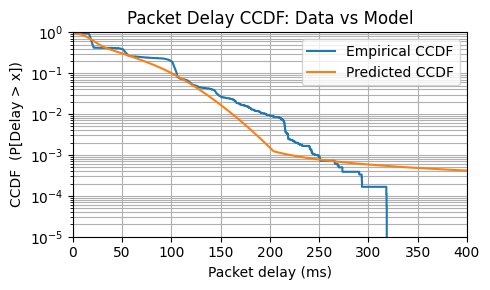

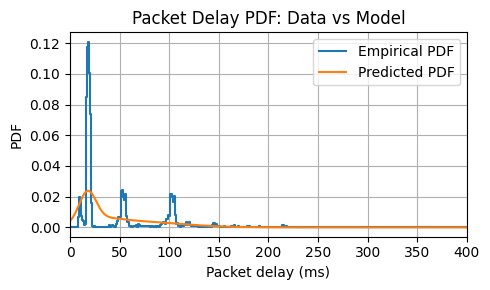

In [47]:
# plot the model prediction
plot_ccdf_pdf_with_model(datasets['e20'], evm_model, 400, y_mean=y_mean, y_std=y_std)

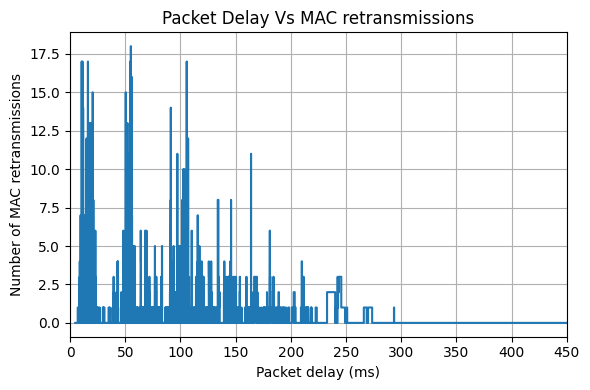

In [ ]:
# Get the no of mac retransmissions
mretx = df['mretx'].tolist()

# plot delay distribution over the number of mac retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, mretx, where='post')       # survival curve style
plt.xlim(0, 450)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of MAC retransmissions')
plt.title('Packet Delay Vs MAC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

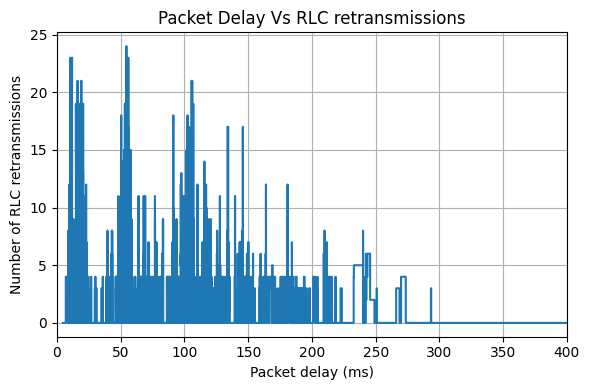

In [ ]:
# Get the no of rlc retransmissions
rlcRetx = df['rfailed'].tolist()

# plot delay distribution over the number of rlc retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, rlcRetx, where='post')       # survival curve style
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of RLC retransmissions')
plt.title('Packet Delay Vs RLC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

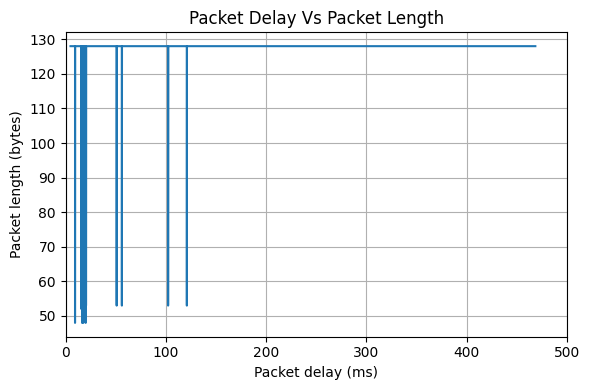

In [ ]:
# Get the packet length
pktLen = df['len'].tolist()

# plot delay distribution over the packet length
plt.figure(figsize=(6, 4))
plt.step(delays, pktLen, where='post')       # survival curve style
plt.xlim(0, 500)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Packet length (bytes)')
plt.title('Packet Delay Vs Packet Length')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()